In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn import linear_model

In [2]:
data_dir = os.getcwd()
tables = {}

In [3]:
for f in list(os.listdir(data_dir)):
    if f[-4:] == ".csv":
        if pd.read_csv(f, sep=',').shape[1] > pd.read_csv(f, sep=';').shape[1]:
            tables[f[:-4]] = pd.read_csv(f, sep=',', names=['time',f[0:-4]])
        else:
            tables[f[:-4]] = pd.read_csv(f, sep=';', names=['time',f[0:-4]])  

In [4]:
tables

{'heat':                       time         heat
 0      2015-06-01 02:00:00   910.344750
 1      2015-06-01 03:00:00   859.474054
 2      2015-06-01 04:00:00   882.489646
 3      2015-06-01 05:00:00   932.948964
 4      2015-06-01 06:00:00   990.662728
 ...                    ...          ...
 24428  2018-03-16 00:00:00  4983.187094
 24429  2018-03-16 01:00:00  4436.284389
 24430  2018-03-16 02:00:00  3979.958712
 24431  2018-03-16 03:00:00  3621.024717
 24432  2018-03-16 04:00:00  3284.236790
 
 [24433 rows x 2 columns],
 'HS1_G1':                       time        HS1_G1
 0      2014-01-01 05:00:00  16447.303810
 1      2014-01-01 06:00:00  16537.577143
 2      2014-01-01 07:00:00  16445.183810
 3      2014-01-01 08:00:00  16362.103810
 4      2014-01-01 09:00:00  15919.877143
 ...                    ...           ...
 36639  2018-03-07 19:00:00  22302.166981
 36640  2018-03-07 20:00:00  22152.534491
 36641  2018-03-07 21:00:00  22099.938270
 36642  2018-03-07 22:00:00  21738.397365

In [5]:
for key,df in tables.items():
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
    df.index = df['time']
    df.drop('time',axis=1,inplace=True)

In [6]:
data = pd.DataFrame()

for key,df in tables.items():
    df = df.groupby(df.index).first()
    data = data.join(df, how='outer')
    print(key, df.shape, data.shape)

heat (24433, 1) (24433, 1)
HS1_G1 (36643, 1) (36840, 2)
HS1_G2 (36643, 1) (36840, 3)
HS1_P1 (36643, 1) (36840, 4)
HS1_P2 (36643, 1) (36840, 5)
HS1_T1 (36643, 1) (36840, 6)
HS1_T2 (36643, 1) (36840, 7)
HS2_G1 (36643, 1) (36840, 8)
HS2_G2 (36643, 1) (36840, 9)
HS2_P1 (36643, 1) (36840, 10)
HS2_P2 (36643, 1) (36840, 11)
HS2_T1 (36643, 1) (36840, 12)
HS2_T2 (36643, 1) (36840, 13)
HS3_G1 (36647, 1) (36844, 14)
node1_T1 (24687, 1) (37084, 15)
node2_T1 (24668, 1) (37084, 16)
node3_T1 (24687, 1) (37084, 17)


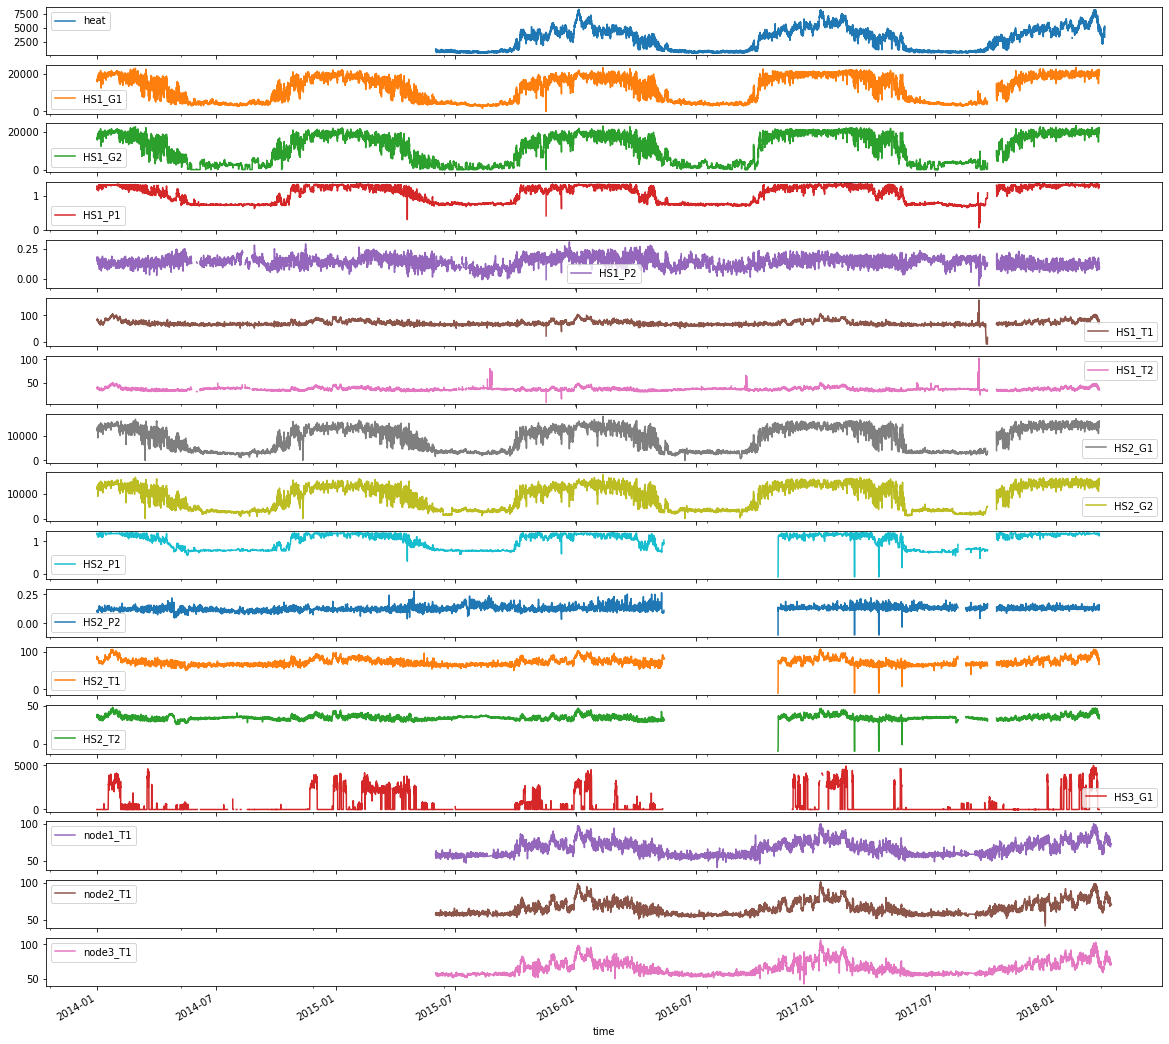

In [7]:
data.plot(subplots=True, figsize=(20,20))
plt.show()

### There are some clear gaps in the data, meaning NaN values need to be addressed. The first heat plant HS1 has the most available data, thus HS1_T1, HS1_T2, and heat are amongst the best parameters to choose for the temperature of substation 1. In order to keep the model statistically sound, outliers are filtered and one model per season is considered. For the sake of simplicity two models will be created: one for the winter and one for the summer, as heat demand and consumption increases during winter times. Additionally, the third heat plant seems to be operational only under specific unknown conditions, therefore it is also worth analyzing if filtering data while the plant is on makes sense. 

In [8]:
sub1 = data.copy()
sub1 = sub1.dropna(axis=0, how='any')
plt.figure(figsize=(20,10));
sub1['node1_T1'].plot();
plt.legend(loc='upper left');
plt.twinx();
sub1['HS1_T1'].plot(color='tab:red');
plt.legend();
plt.show();

### This graph shows that some outliers need to be filtered. It is also helpful, because it shows a clear distinction in heat transfer between the seasons, during summer times staying at low values around 60°C, and during winter time ranging between 70-90°C. Periods with missing data are connected with a straight line which can be ignored. 

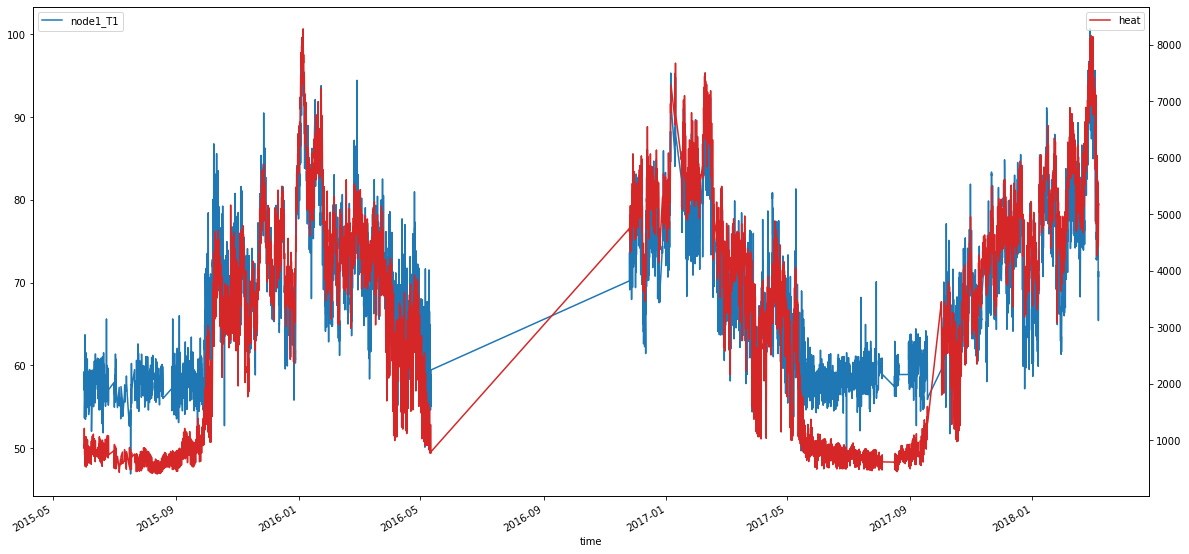

In [9]:
plt.figure(figsize=(20,10));
sub1['node1_T1'].plot();
plt.legend(loc='upper left');
plt.twinx();
sub1['heat'].plot(color='tab:red');
plt.legend();
plt.show();

### This graph also shows a clear distinction in heat transfer between the seasons, during summer times staying at low values below 1500 and during winter time going as high as 8000. Periods with missing data are connected with a straight line which can be ignored. 

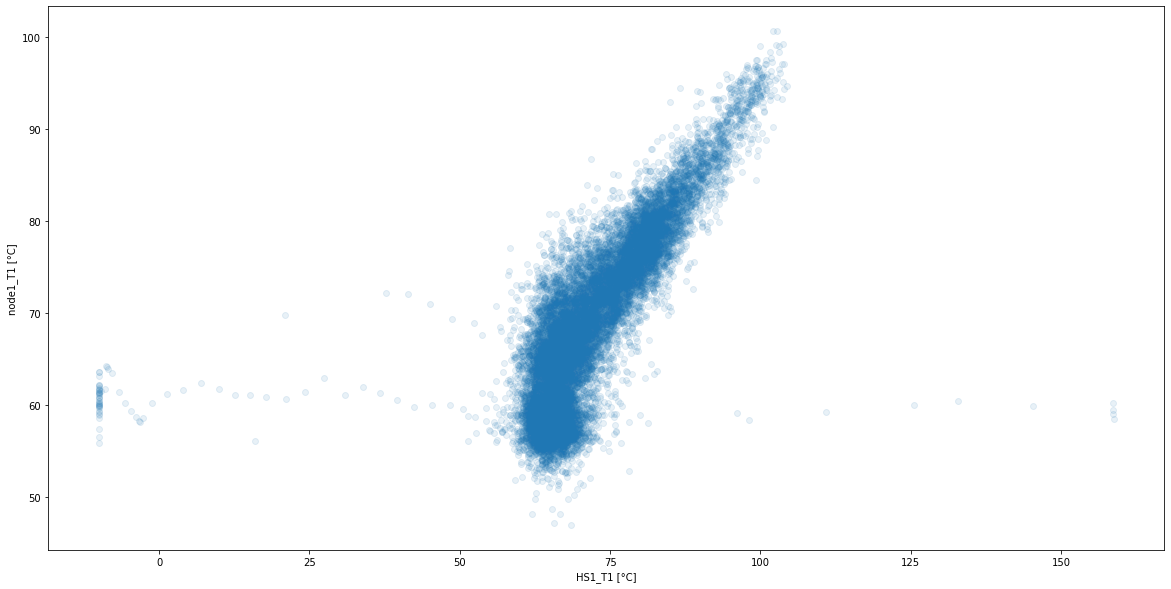

In [10]:
plt.figure(figsize=(20,10))
plt.scatter(sub1['HS1_T1'],sub1['node1_T1'], alpha=0.1);
plt.xlabel('HS1_T1 [°C]');
plt.ylabel('node1_T1 [°C]');

In [11]:
plt.figure(figsize=(20,10))
plt.scatter(sub1['heat'],sub1['node1_T1'], alpha=0.1);
plt.xlabel('heat');
plt.ylabel('node1_T1 [°C]');

### These scatter plots prove the linear behavior between both parameters and the presence of outliers that need to be filtered. The plots can also be considered to contain "two" lines with different slopes, which can be obtained separately by splitting the data between winter and summer. Furthermore, the scatterplot for heat shows that it has a more linear behavior than HS1_T1

In [12]:
plt.figure(figsize=(20,10));
sub1.loc[sub1['HS3_G1']<100, 'HS3_G1'].hist(bins=40);

### The histogram proves that most of the time heating plant 3 is off. Therefore, all data when the plant is on will be deleted.

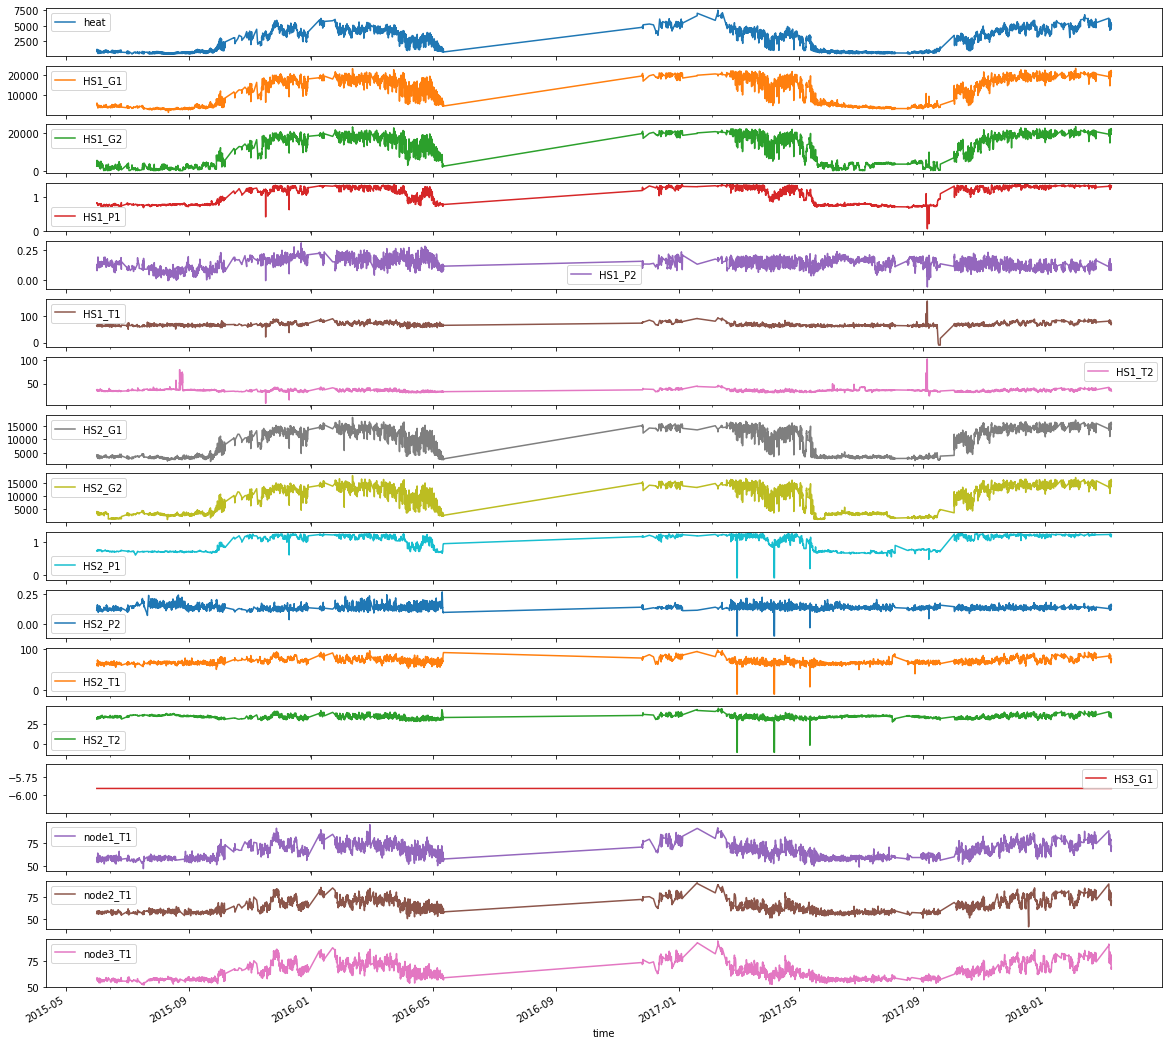

In [13]:
#Filtering  for all values of when HS3 is off:
sub1 = sub1[sub1['HS3_G1'] <= 0]
sub1.plot(subplots=True, figsize=(20,20));

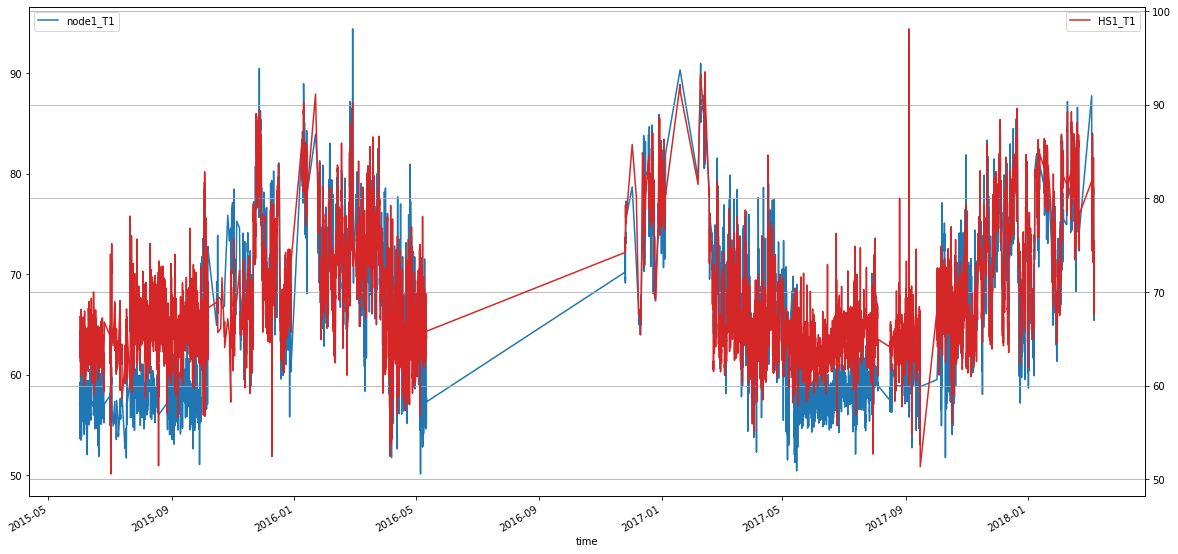

In [14]:
#filtering for notorious outliers
sub1 = sub1[(sub1['node1_T1'] < 100) & (sub1['node1_T1'] > 50)]
sub1 = sub1[(sub1['HS1_T1'] < 100) & (sub1['HS1_T1'] > 50)]
plt.figure(figsize=(20,10));
sub1['node1_T1'].plot();
plt.legend(loc='upper left');
plt.twinx();
sub1['HS1_T1'].plot(color='tab:red');
plt.grid();
plt.legend();
plt.show();

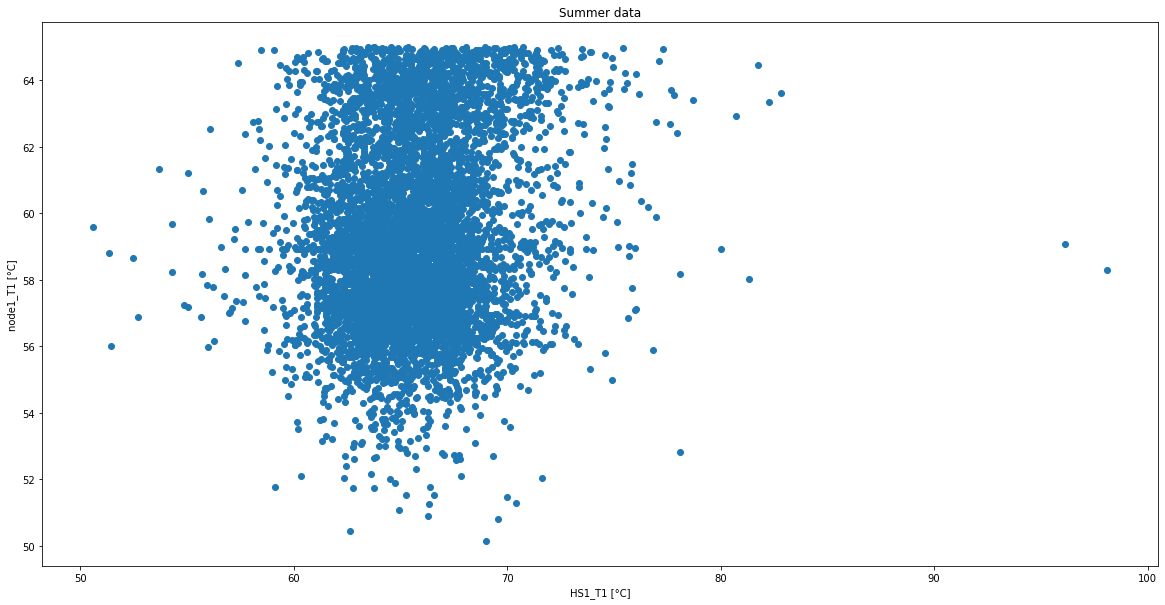

In [15]:
#separating datasets by winter and summer sessions using temperature of substation
sub1_summer = sub1[(sub1['node1_T1'] <= 65)]
sub1_winter = sub1[sub1['node1_T1'] > 65]
plt.figure(figsize=(20,10))
plt.scatter(sub1_summer['HS1_T1'],sub1_summer['node1_T1']);
plt.xlabel('HS1_T1 [°C]');
plt.ylabel('node1_T1 [°C]');
plt.title('Summer data');

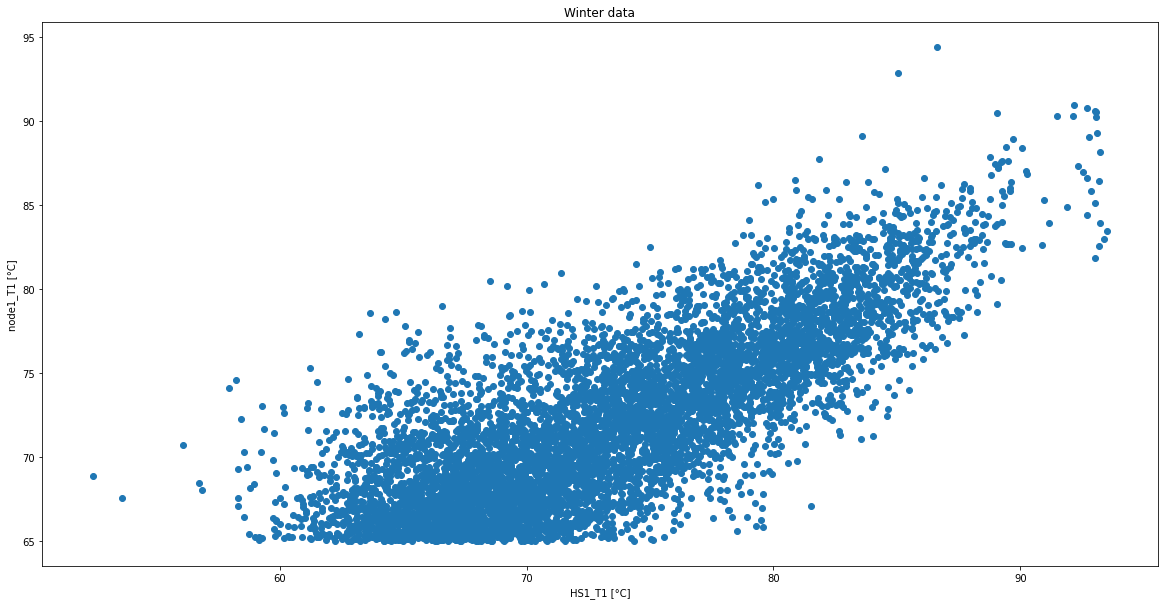

In [16]:
plt.figure(figsize=(20,10))
plt.scatter(sub1_winter['HS1_T1'],sub1_winter['node1_T1']);
plt.xlabel('HS1_T1 [°C]');
plt.ylabel('node1_T1 [°C]');
plt.title('Winter data');

### It can be observed that both scatter plots now have a unique linear behavior. The temperature of the heating plant can be delayed, as the temperature in the substation does not increase at the same pace of the plant. 

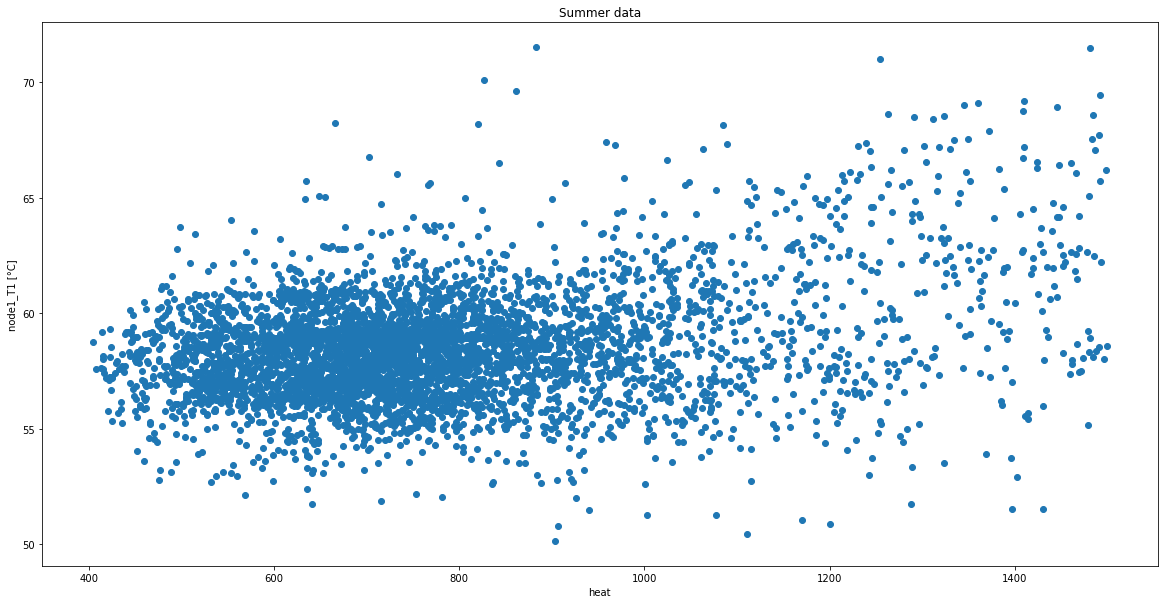

In [54]:
#separating datasets by winter and summer sessions using heat
sub2_summer = sub1[(sub1['heat'] <= 1500)]
sub2_winter = sub1[sub1['heat'] > 1500]
plt.figure(figsize=(20,10))
plt.scatter(sub2_summer['heat'],sub2_summer['node1_T1']);
plt.xlabel('heat');
plt.ylabel('node1_T1 [°C]');
plt.title('Summer data');

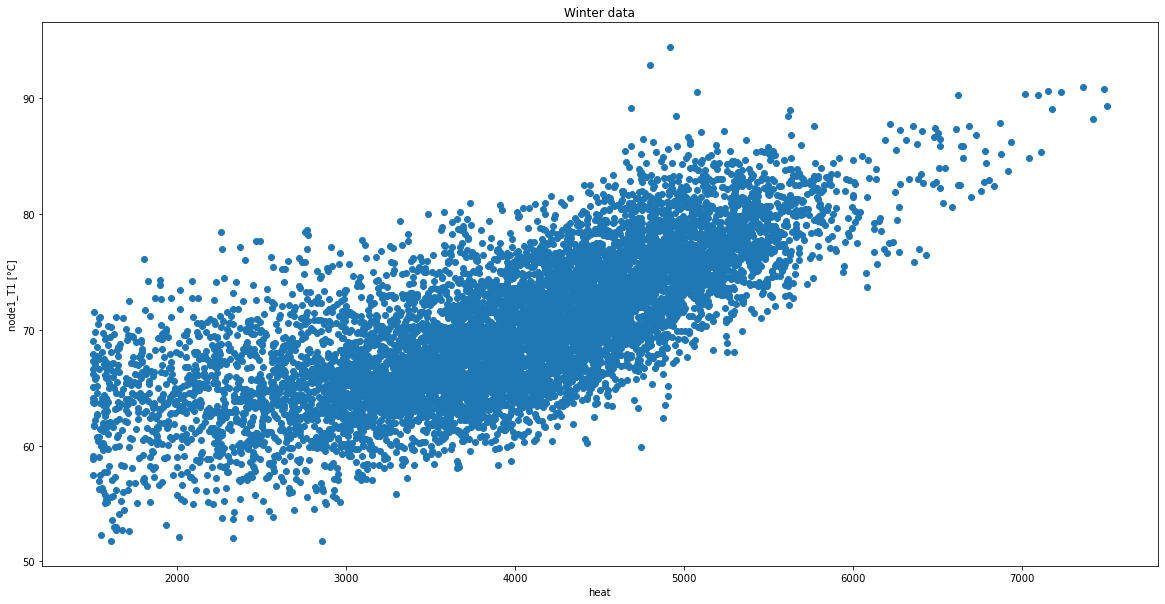

In [53]:
plt.figure(figsize=(20,10))
plt.scatter(sub2_winter['heat'],sub2_winter['node1_T1']);
plt.xlabel('heat');
plt.ylabel('node1_T1 [°C]');
plt.title('Winter data');

### Separating the data sets by using the heat limits as a parameter seems to show a more linear behavior for both sets. This needs to be proved by using R2 parameter.

In [17]:
sub1 = sub1.drop(columns=['HS3_G1'])
corr_matrix = sub1.corr()
corr_matrix

heat    HS1_G1    HS1_G2    HS1_P1    HS1_P2    HS1_T1  \
heat      1.000000  0.960797  0.953875  0.943055  0.244104  0.704986   
HS1_G1    0.960797  1.000000  0.989798  0.952424  0.254601  0.556203   
HS1_G2    0.953875  0.989798  1.000000  0.944865  0.264592  0.556155   
HS1_P1    0.943055  0.952424  0.944865  1.000000  0.220682  0.605100   
HS1_P2    0.244104  0.254601  0.264592  0.220682  1.000000  0.054556   
HS1_T1    0.704986  0.556203  0.556155  0.605100  0.054556  1.000000   
HS1_T2    0.095525 -0.011953 -0.037799  0.012612 -0.130933  0.430982   
HS2_G1    0.958722  0.990228  0.981443  0.958944  0.266163  0.556627   
HS2_G2    0.954627  0.985035  0.977160  0.960371  0.251289  0.559347   
HS2_P1    0.908428  0.909057  0.904860  0.957010  0.274556  0.579855   
HS2_P2   -0.100726 -0.060110 -0.073680 -0.082933 -0.041633 -0.072654   
HS2_T1    0.590439  0.452335  0.459506  0.498560  0.143070  0.777856   
HS2_T2    0.160937  0.061017  0.049074  0.082098 -0.117365  0.429918   
node1_T1  0.878339  0.781149  0.783919  0.795580  0.234040  0.795496   
node2_T1  0.880695  0.759977  0.757284  0.781822  0.133375  0.842283   
node3_T1  0.902663  0.794674  0.794318  0.807326  0.182377  0.816084   

            HS1_T2    HS2_G1    HS2_G2    HS2_P1    HS2_P2    HS2_T1  \
heat      0.095525  0.958722  0.954627  0.908428 -0.100726  0.590439   
HS1_G1   -0.011953  0.990228  0.985035  0.909057 -0.060110  0.452335   
HS1_G2   -0.037799  0.981443  0.977160  0.904860 -0.073680  0.459506   
HS1_P1    0.012612  0.958944  0.960371  0.957010 -0.082933  0.498560   
HS1_P2   -0.130933  0.266163  0.251289  0.274556 -0.041633  0.143070   
HS1_T1    0.430982  0.556627  0.559347  0.579855 -0.072654  0.777856   
HS1_T2    1.000000 -0.009588 -0.002038 -0.002965  0.101846  0.344373   
HS2_G1   -0.009588  1.000000  0.996509  0.921377 -0.059007  0.450847   
HS2_G2   -0.002038  0.996509  1.000000  0.918269 -0.041831  0.449432   
HS2_P1   -0.002965  0.921377  0.918269  1.000000 -0.005416  0.603950   
HS2_P2    0.101846 -0.059007 -0.041831 -0.005416  1.000000  0.103549   
HS2_T1    0.344373  0.450847  0.449432  0.603950  0.103549  1.000000   
HS2_T2    0.567376  0.067561  0.071809  0.220075  0.358805  0.628371   
node1_T1  0.223751  0.777257  0.772696  0.780501 -0.178245  0.705557   
node2_T1  0.283077  0.760852  0.758475  0.754489 -0.125895  0.705380   
node3_T1  0.248142  0.791888  0.788147  0.782670 -0.142415  0.695996   

            HS2_T2  node1_T1  node2_T1  node3_T1  
heat      0.160937  0.878339  0.880695  0.902663  
HS1_G1    0.061017  0.781149  0.759977  0.794674  
HS1_G2    0.049074  0.783919  0.757284  0.794318  
HS1_P1    0.082098  0.795580  0.781822  0.807326  
HS1_P2   -0.117365  0.234040  0.133375  0.182377  
HS1_T1    0.429918  0.795496  0.842283  0.816084  
HS1_T2    0.567376  0.223751  0.283077  0.248142  
HS2_G1    0.067561  0.777257  0.760852  0.791888  
HS2_G2    0.071809  0.772696  0.758475  0.788147  
HS2_P1    0.220075  0.780501  0.754489  0.782670  
HS2_P2    0.358805 -0.178245 -0.125895 -0.142415  
HS2_T1    0.628371  0.705557  0.705380  0.695996  
HS2_T2    1.000000  0.273389  0.334134  0.296561  
node1_T1  0.273389  1.000000  0.897508  0.902144  
node2_T1  0.334134  0.897508  1.000000  0.955693  
node3_T1  0.296561  0.902144  0.955693  1.000000

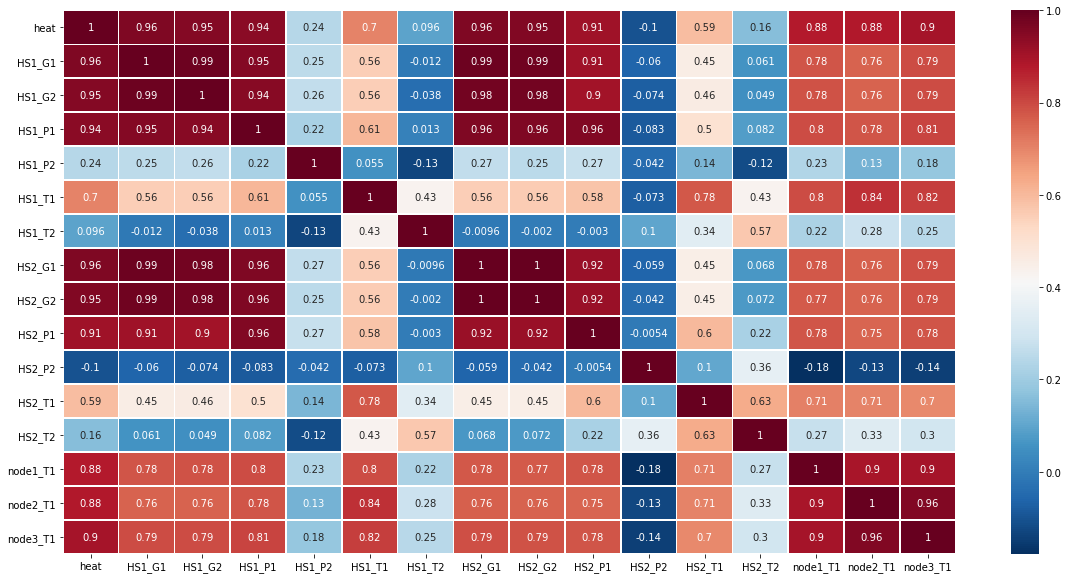

In [18]:
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns,cmap='RdBu_r',
            annot=True,linewidth=0.5);

### Correlation matrix for the filtered data shows that the best variable for substation 1 is heat . A value closer to unity means the variable is able to represent the dependent variable accurately. Even though the other substation's temperatures have a vaue closer to 1, it doesn't make sense to consider these parameters as they don't supply heat to the network. Additionally, it is not realistic to expect a value of 1, given that physically other variables affect the temperature at the substation. With this in mind the most important parameters are heat, temperature of the supply station, and the mass flow. 

In [19]:
for Delay in range(1,24):
    sub1["HS1_T1_del_"+str(Delay)]=pd.concat(
        [pd.DataFrame([{sub1[["HS1_T1"]].columns[0]: np.nan} for i in range(0,Delay)]),
                                    sub1[["HS1_T1"]]], axis = 0).drop(sub1["HS1_T1"].tail(Delay).index).values

In [20]:
corr_matrix_del = sub1.corr()
corr_matrix_del

heat    HS1_G1    HS1_G2    HS1_P1    HS1_P2    HS1_T1  \
heat           1.000000  0.960797  0.953875  0.943055  0.244104  0.704986   
HS1_G1         0.960797  1.000000  0.989798  0.952424  0.254601  0.556203   
HS1_G2         0.953875  0.989798  1.000000  0.944865  0.264592  0.556155   
HS1_P1         0.943055  0.952424  0.944865  1.000000  0.220682  0.605100   
HS1_P2         0.244104  0.254601  0.264592  0.220682  1.000000  0.054556   
HS1_T1         0.704986  0.556203  0.556155  0.605100  0.054556  1.000000   
HS1_T2         0.095525 -0.011953 -0.037799  0.012612 -0.130933  0.430982   
HS2_G1         0.958722  0.990228  0.981443  0.958944  0.266163  0.556627   
HS2_G2         0.954627  0.985035  0.977160  0.960371  0.251289  0.559347   
HS2_P1         0.908428  0.909057  0.904860  0.957010  0.274556  0.579855   
HS2_P2        -0.100726 -0.060110 -0.073680 -0.082933 -0.041633 -0.072654   
HS2_T1         0.590439  0.452335  0.459506  0.498560  0.143070  0.777856   
HS2_T2         0.160937  0.061017  0.049074  0.082098 -0.117365  0.429918   
node1_T1       0.878339  0.781149  0.783919  0.795580  0.234040  0.795496   
node2_T1       0.880695  0.759977  0.757284  0.781822  0.133375  0.842283   
node3_T1       0.902663  0.794674  0.794318  0.807326  0.182377  0.816084   
HS1_T1_del_1   0.702699  0.551400  0.551740  0.600765  0.043756  0.959984   
HS1_T1_del_2   0.702810  0.548297  0.548604  0.597112  0.035382  0.922489   
HS1_T1_del_3   0.704861  0.547237  0.547190  0.593498  0.032781  0.895237   
HS1_T1_del_4   0.706467  0.548021  0.547649  0.590274  0.032503  0.871227   
HS1_T1_del_5   0.707158  0.549770  0.549160  0.587619  0.031932  0.849577   
HS1_T1_del_6   0.706838  0.552182  0.551250  0.585225  0.032381  0.828432   
HS1_T1_del_7   0.705548  0.554782  0.553434  0.583257  0.033448  0.807396   
HS1_T1_del_8   0.704217  0.557509  0.556002  0.582135  0.034087  0.789368   
HS1_T1_del_9   0.702794  0.560425  0.558644  0.581437  0.033849  0.775584   
HS1_T1_del_10  0.701283  0.563412  0.561386  0.581218  0.034064  0.764107   
HS1_T1_del_11  0.699740  0.566454  0.564126  0.581441  0.034076  0.752662   
HS1_T1_del_12  0.698391  0.569106  0.566281  0.582010  0.034727  0.743979   
HS1_T1_del_13  0.696902  0.571510  0.568288  0.582720  0.035293  0.736752   
HS1_T1_del_14  0.695291  0.573501  0.570060  0.583557  0.035301  0.731307   
HS1_T1_del_15  0.693526  0.575014  0.571495  0.584474  0.033446  0.728002   
HS1_T1_del_16  0.691637  0.575913  0.572326  0.585365  0.032796  0.726262   
HS1_T1_del_17  0.689639  0.576596  0.572876  0.586399  0.034029  0.725443   
HS1_T1_del_18  0.687175  0.576781  0.572996  0.587359  0.036194  0.726837   
HS1_T1_del_19  0.684678  0.576699  0.572750  0.588288  0.036857  0.728876   
HS1_T1_del_20  0.681914  0.576305  0.572317  0.588893  0.037862  0.731950   
HS1_T1_del_21  0.679374  0.575519  0.571518  0.589262  0.039201  0.734278   
HS1_T1_del_22  0.677084  0.573994  0.570281  0.589122  0.041190  0.735628   
HS1_T1_del_23  0.674901  0.572168  0.568838  0.588664  0.041992  0.735721   

                 HS1_T2    HS2_G1    HS2_G2    HS2_P1  ...  HS1_T1_del_14  \
heat           0.095525  0.958722  0.954627  0.908428  ...       0.695291   
HS1_G1        -0.011953  0.990228  0.985035  0.909057  ...       0.573501   
HS1_G2        -0.037799  0.981443  0.977160  0.904860  ...       0.570060   
HS1_P1         0.012612  0.958944  0.960371  0.957010  ...       0.583557   
HS1_P2        -0.130933  0.266163  0.251289  0.274556  ...       0.035301   
HS1_T1         0.430982  0.556627  0.559347  0.579855  ...       0.731307   
HS1_T2         1.000000 -0.009588 -0.002038 -0.002965  ...       0.300133   
HS2_G1        -0.009588  1.000000  0.996509  0.921377  ...       0.573577   
HS2_G2        -0.002038  0.996509  1.000000  0.918269  ...       0.573061   
HS2_P1        -0.002965  0.921377  0.918269  1.000000  ...       0.553682   
HS2_P2         0.101846 -0.059007 -0.041831 -0.005416  ...      -0.065993   
HS2_T1        

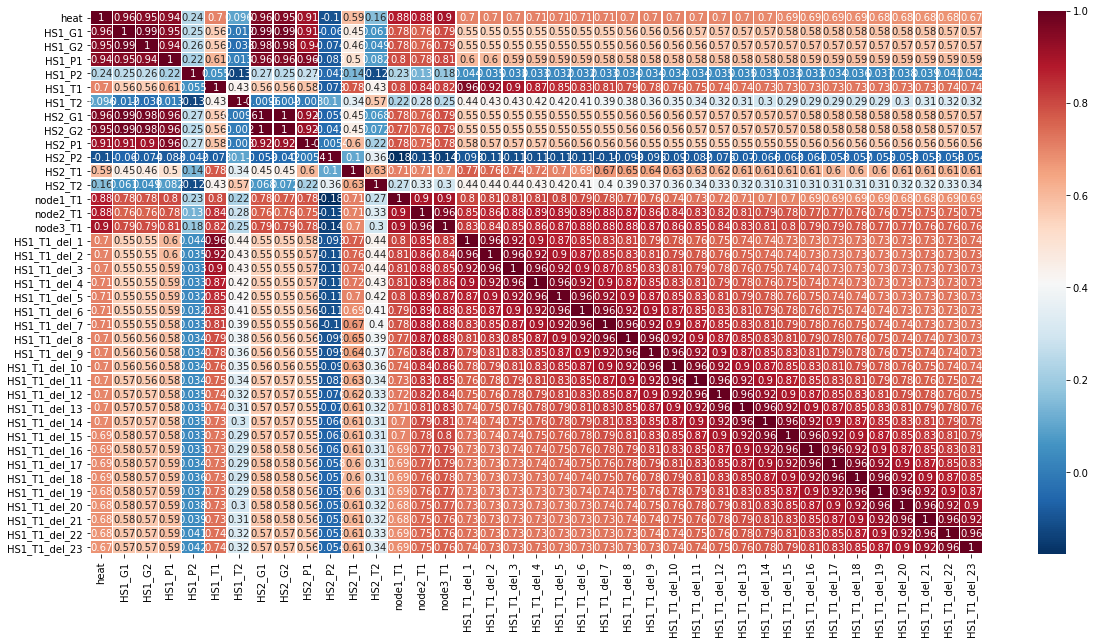

In [21]:
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix_del, xticklabels=corr_matrix_del.columns, yticklabels=corr_matrix_del.columns,cmap='RdBu_r',
            annot=True,linewidth=0.5);

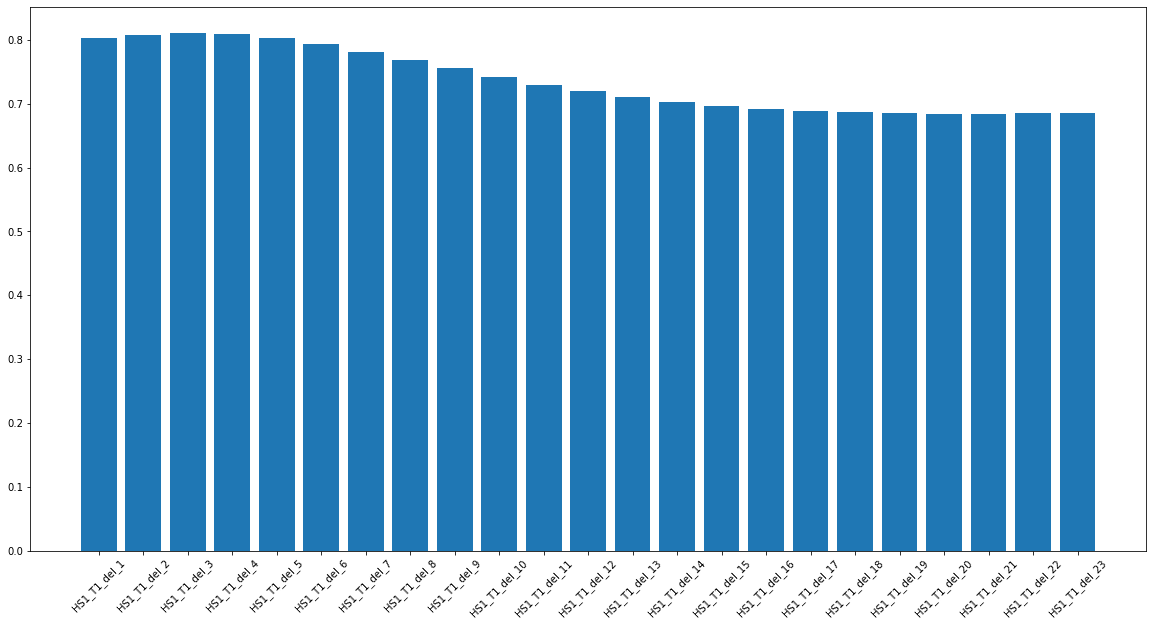

In [22]:
plt.figure(figsize=(20,10))
plt.bar(sub1.columns[16:], sub1.corr()['node1_T1'].values[16:]);
plt.xticks(rotation=45);
plt.plot();

### It makes sense to delay temperature supplied by the substation, in contrary delaying heat transfer makes little sense as power is already a measurement of the rate of energy transfer. From the barplot it can be seen that the highest pearson coefficient is for delays of 3-4 hours.

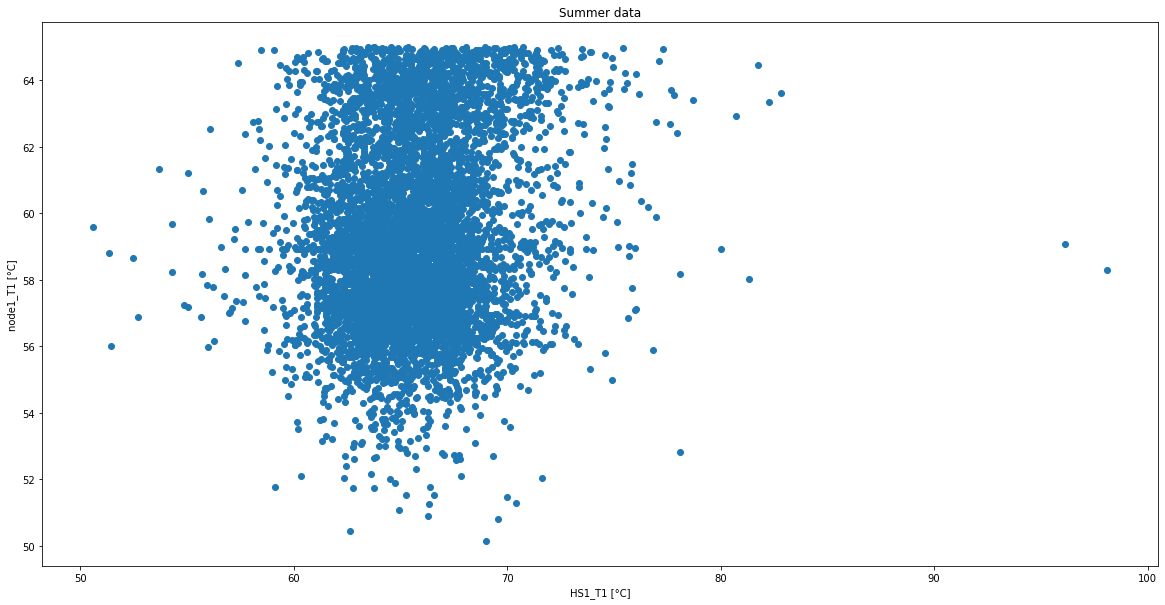

In [23]:
sub1_summer = sub1[sub1['node1_T1'] <= 65]
sub1_winter = sub1[sub1['node1_T1'] > 65]
plt.figure(figsize=(20,10))
plt.scatter(sub1_summer['HS1_T1'],sub1_summer['node1_T1']);
plt.xlabel('HS1_T1 [°C]');
plt.ylabel('node1_T1 [°C]');
plt.title('Summer data');

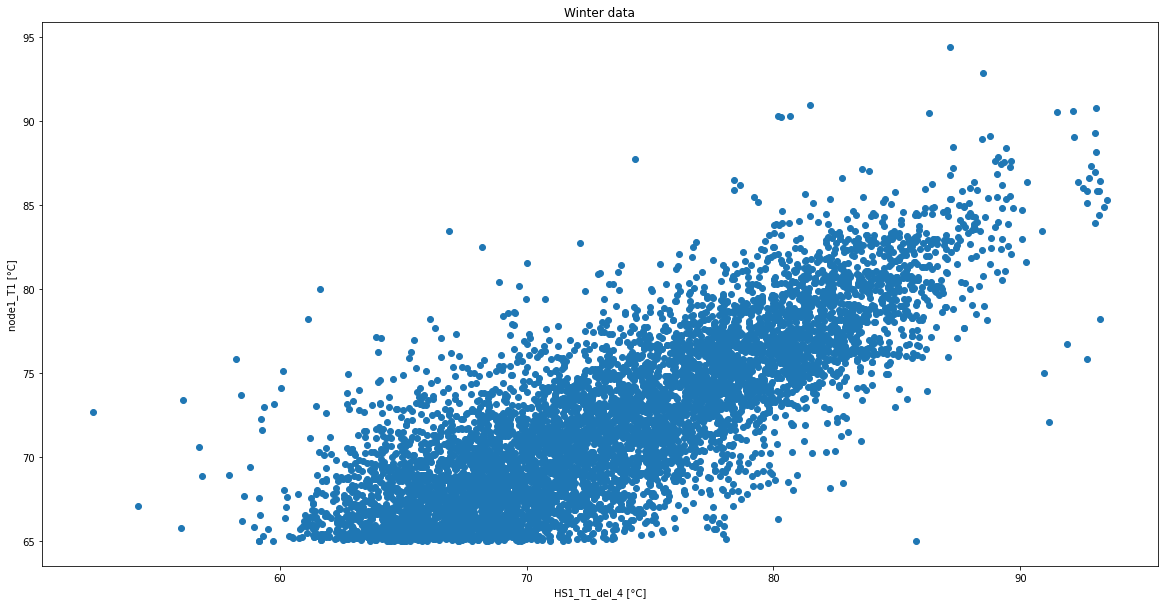

In [57]:
plt.figure(figsize=(20,10))
plt.scatter(sub1_winter['HS1_T1_del_4'],sub1_winter['node1_T1']);
plt.xlabel('HS1_T1_del_4 [°C]');
plt.ylabel('node1_T1 [°C]');
plt.title('Winter data');

### For summer no delays will be considered given that the consumption is considerably lower, in winter a delay of 4 hours is considered due to its higher pearson number and the possible slower changes in temperature across the network as a whole. 

In [25]:
#Evaluation of summer model with temperature as input
reg_summer = linear_model.LinearRegression()
reg_summer.fit(sub1_summer['HS1_T1'].values.reshape(-1,1), sub1_summer['node1_T1'])

LinearRegression()

In [26]:
reg_summer.score(sub1_summer['HS1_T1'].values.reshape(-1,1), sub1_summer['node1_T1'])

0.019941577993297877

In [27]:
y_pred_summer = reg_summer.predict(sub1_summer['HS1_T1'].values.reshape(-1,1))

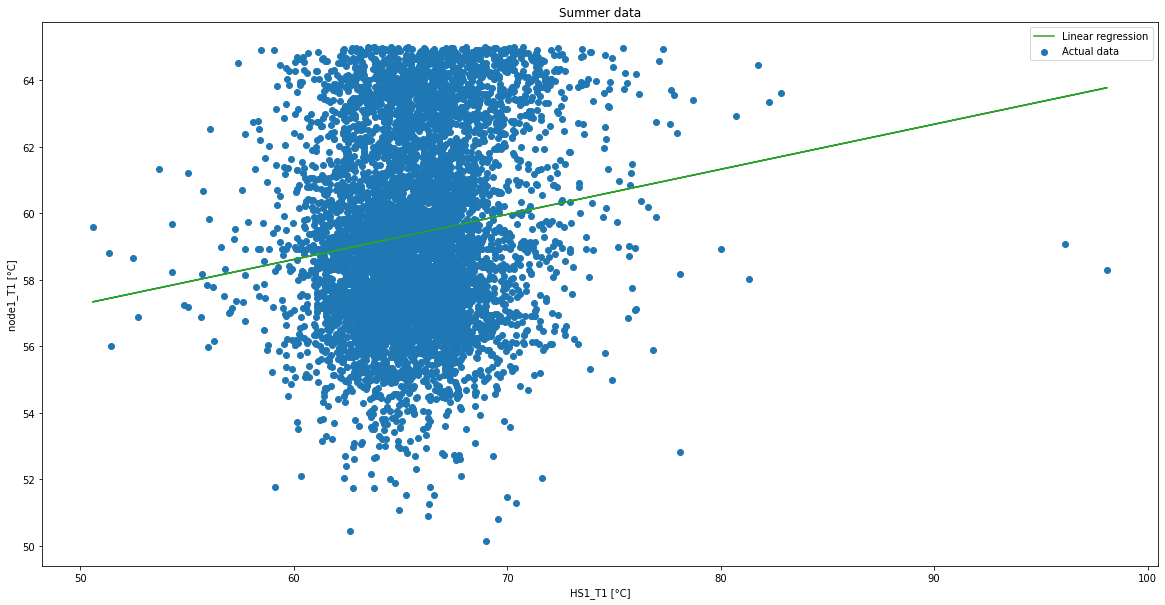

In [28]:
plt.figure(figsize=(20,10))
plt.scatter(sub1_summer['HS1_T1'],sub1_summer['node1_T1'], label='Actual data');
plt.plot(sub1_summer['HS1_T1'], y_pred_summer, color='tab:green', label='Linear regression');
plt.xlabel('HS1_T1 [°C]');
plt.ylabel('node1_T1 [°C]');
plt.legend();
plt.title('Summer data');

### The score and the plot show that the linear regression is quite inaccurate for the summer model, by barely scoring almost 2% for R2. This means the temperature of the first heating plant is not able to linearly describe the temperature at the first substation.

In [48]:
#Evaluation of summer model with heat as imput
reg_summer2 = linear_model.LinearRegression()
reg_summer2.fit(sub2_summer['heat'].values.reshape(-1,1), sub2_summer['node1_T1'])

LinearRegression()

In [49]:
reg_summer2.score(sub2_summer['heat'].values.reshape(-1,1), sub2_summer['node1_T1'])

0.0924755483348898

In [50]:
y_pred_summer2 = reg_summer2.predict(sub2_summer['heat'].values.reshape(-1,1))

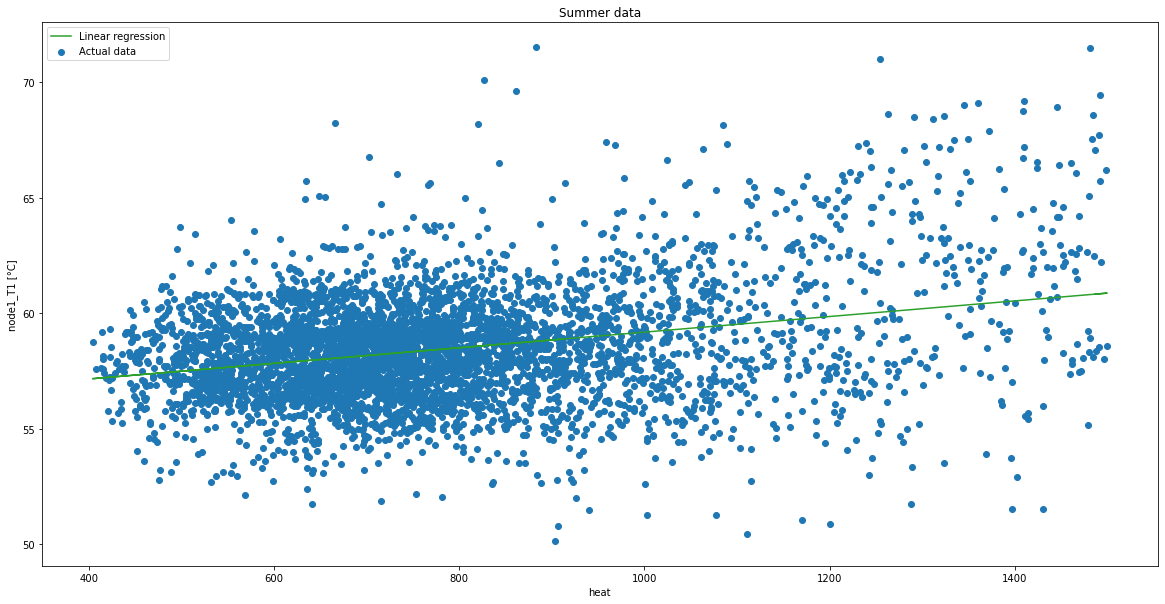

In [52]:
plt.figure(figsize=(20,10))
plt.scatter(sub2_summer['heat'],sub2_summer['node1_T1'], label='Actual data');
plt.plot(sub2_summer['heat'], y_pred_summer2, color='tab:green', label='Linear regression');
plt.xlabel('heat');
plt.ylabel('node1_T1 [°C]');
plt.legend();
plt.title('Summer data');

### Using heat as the independent variable is still not accurate, but definitely better than using temperature 1 of the first heating plant, as the R2 increases from 1.9% to 9.2%. The scatter plot shows that the data is still too dispersed, and a linear model of one input is not enough to make accurate predictions. 

In [31]:
#Evaluation of winter model with temperature as imput
reg_winter = linear_model.LinearRegression()
reg_winter.fit(sub1_winter['HS1_T1_del_4'].values.reshape(-1,1), sub1_winter['node1_T1'])

LinearRegression()

In [32]:
reg_winter.score(sub1_winter['HS1_T1_del_4'].values.reshape(-1,1), sub1_winter['node1_T1'])

0.651427646808568

In [33]:
y_pred_winter = reg_winter.predict(sub1_winter['HS1_T1_del_4'].values.reshape(-1,1))

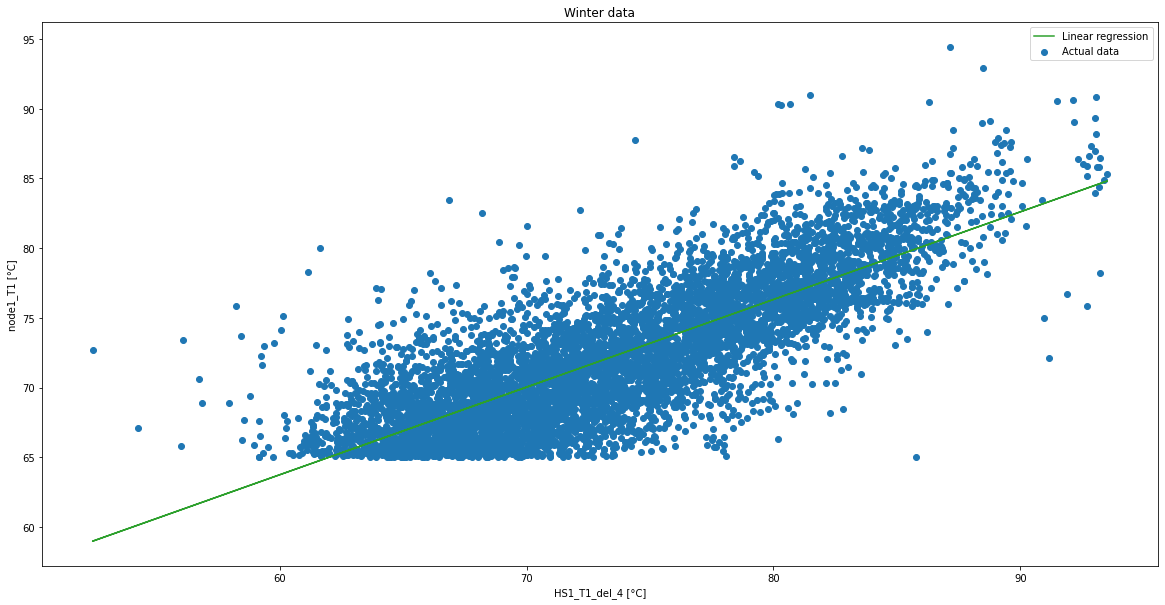

In [34]:
plt.figure(figsize=(20,10))
plt.scatter(sub1_winter['HS1_T1_del_4'],sub1_winter['node1_T1'], label='Actual data');
plt.plot(sub1_winter['HS1_T1_del_4'], y_pred_winter, color='tab:green', label='Linear regression')
plt.xlabel('HS1_T1_del_4 [°C]');
plt.ylabel('node1_T1 [°C]');
plt.legend();
plt.title('Winter data');

### As expected the winter model is more accurate, since the scatter plot shows a more obvious linear trend between the dependent and independent variable. A 65% R2 indicates a relatively high score compared to the summer model while using supply temperature 1. 

In [58]:
#Evaluation of winter model with heat as imput
reg_winter2 = linear_model.LinearRegression()
reg_winter2.fit(sub2_winter['heat'].values.reshape(-1,1), sub2_winter['node1_T1'])

LinearRegression()

In [59]:
reg_winter2.score(sub2_winter['heat'].values.reshape(-1,1), sub2_winter['node1_T1'])

0.5401711146717058

In [60]:
y_pred_winter2 = reg_winter2.predict(sub2_winter['heat'].values.reshape(-1,1))

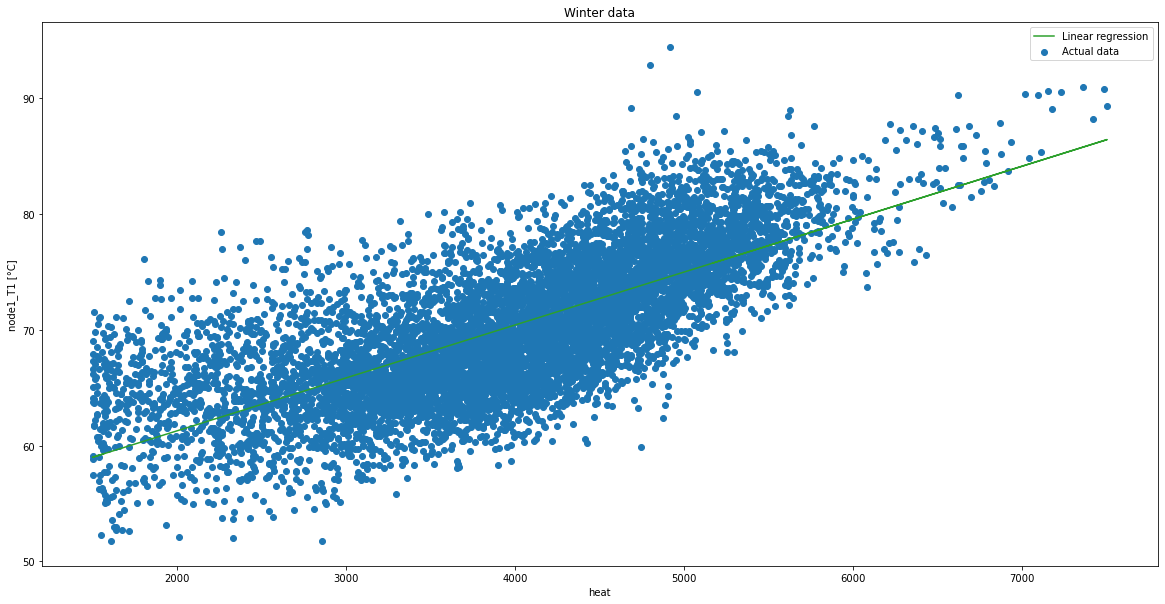

In [61]:
plt.figure(figsize=(20,10))
plt.scatter(sub2_winter['heat'],sub2_winter['node1_T1'], label='Actual data');
plt.plot(sub2_winter['heat'], y_pred_winter2, color='tab:green', label='Linear regression');
plt.xlabel('heat');
plt.ylabel('node1_T1 [°C]');
plt.legend();
plt.title('Winter data');

### The winter model by using heat is less acurrate than using the supply temperature 1, as the R2 for this model is around 10% less at 54%. Based on R2 scores, the best model for predicting node1_T1 temperatures would be a combination of the summer model using heat as input, and the winter model using HS1_T1 as the input.

In [29]:
#Correlation matrix for summer to find additional inputs
corr_matrix_summer = sub1_summer.corr()

In [30]:
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix_summer, xticklabels=corr_matrix_summer.columns, yticklabels=corr_matrix_summer.columns,
            cmap='RdBu_r', annot=True,linewidth=0.5);

### Additional parameters selected are those with the highest pearson coefficients: heat, HS1_G2, HS2_G1

In [64]:
#Increase of summer model quality by adding better-suited parameters
reg_summer_1 = linear_model.LinearRegression()
reg_summer_1.fit(sub1_summer[['heat','HS1_T1','HS1_G2','HS2_G1']], sub1_summer['node1_T1'])

LinearRegression()

In [65]:
reg_summer_1.score(sub1_summer[['heat','HS1_T1','HS1_G2','HS2_G1']], sub1_summer['node1_T1'])

0.4664206583169196

In [92]:
reg_summer_1.coef_

array([ 0.00219089,  0.09158439,  0.00013776, -0.00035828])

In [93]:
reg_summer_1.intercept_

51.50364601630728

### The equation for the linear regression has the shape of: 
y = 51.50364601630728 + 0.00219089(heat) + 0.09158439(HS1_T1) + 0.00013776(HS1_G2) - 0.00035828(HS2_G1)

### The score of the summer model, when data is filtered by the substation's temperature, increases significantly from 2% to 46% by adding inputs that have a higher pearson correlation.

In [68]:
corr_matrix_summer2 = sub2_summer.corr()

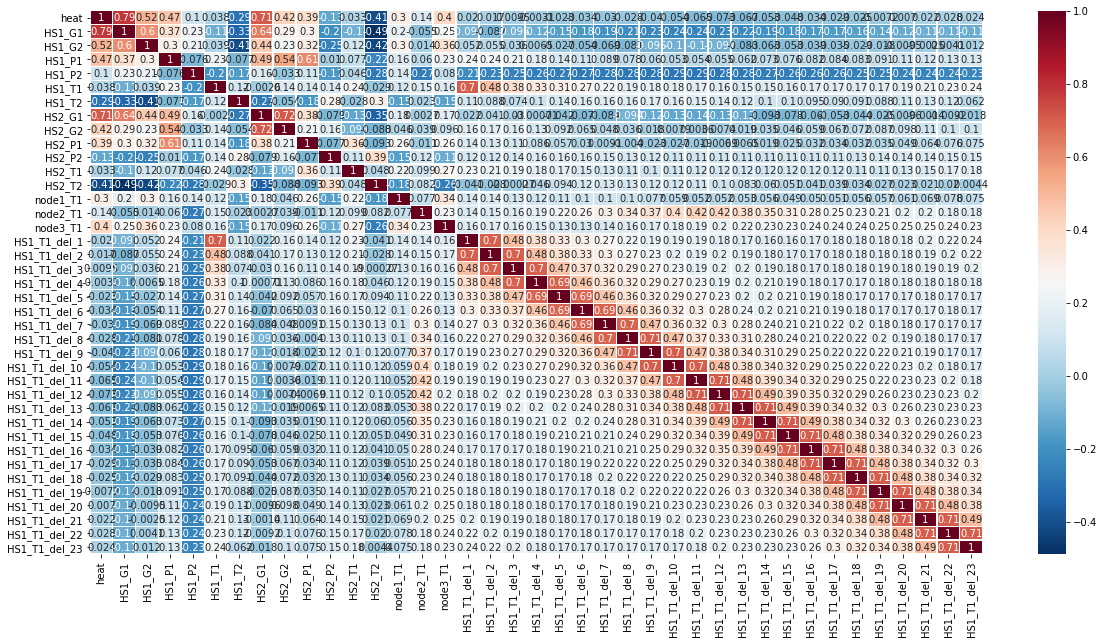

In [69]:
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix_summer2, xticklabels=corr_matrix_summer2.columns, yticklabels=corr_matrix_summer2.columns,
            cmap='RdBu_r', annot=True,linewidth=0.5);

### When using heat to filter the data, the correlations for all parameters are quite low, which will lead to a model of lower accuracy. It is however proven that the correlation by using heat as input is 0.3, while using HS1_T1 on the previous matrix it is 0.14. Consequently, this explains the results obtained from the previous scatter plots and their respective linear regression models, where the more accurate model used heat. 

In [70]:
#Analysis for the summer model when filtered by heat
reg_summer_2 = linear_model.LinearRegression()
reg_summer_2.fit(sub2_summer[['heat','HS2_T1','HS1_G2','HS1_G1']], sub2_summer['node1_T1'])

LinearRegression()

In [71]:
reg_summer_2.score(sub2_summer[['heat','HS2_T1','HS1_G2','HS1_G1']], sub2_summer['node1_T1'])

0.16139087990576895

In [97]:
reg_summer_2.coef_

array([ 0.00338078,  0.08888249,  0.00026093, -0.0002713 ])

In [96]:
reg_summer_2.intercept_

50.42344013295554

### The equation for the linear regression has the shape of: 
y = 50.42344013295554 + 0.00338078(heat) + 0.08888249(HS2_T1) + 0.00026093(HS1_G2) - 0.0002713(HS1_G1)

### As mentioned before, this model is quite inaccurate even by adding new inputs, as the score only increases from 9% to 16%. Compared to the summer model with 4 inputs when the data is filtered according to the substation's temperature with an R2 value of 46%.

In [35]:
corr_matrix_winter = sub1_winter.corr()

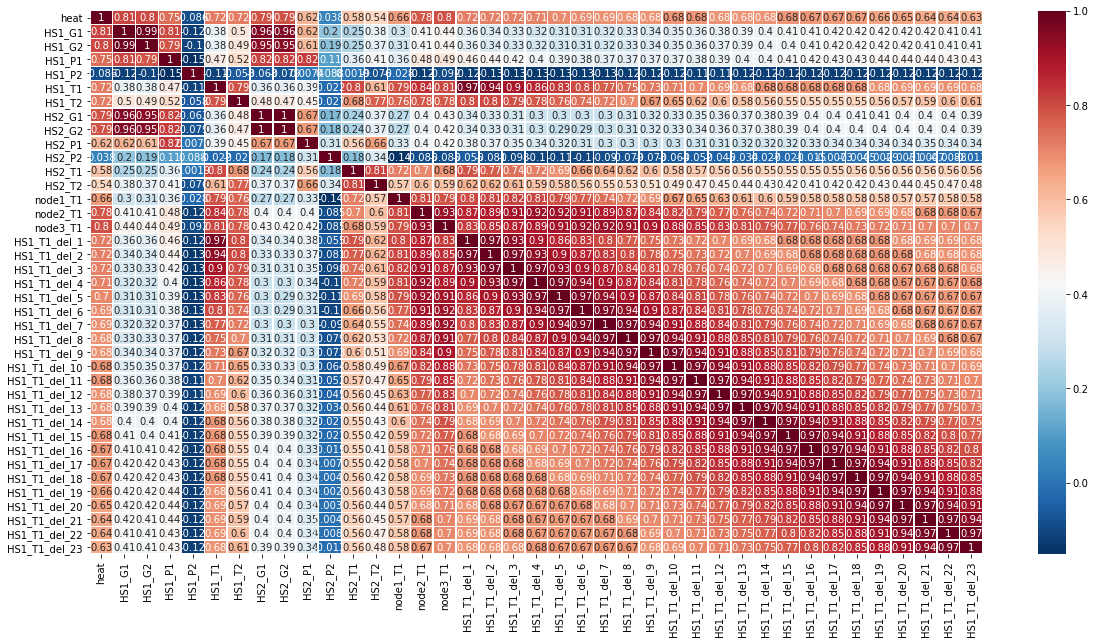

In [36]:
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix_winter, xticklabels=corr_matrix_winter.columns, yticklabels=corr_matrix_winter.columns,
            cmap='RdBu_r', annot=True,linewidth=0.5);

### As seen from previous data, the correlations for the winter model are quite high. The parameters with highest correlations are: heat, HS_T1_del4, HS1_T2, and HS2_T1. Even though HS_T1 is also high, it is not considered as its delayed verison is included.

In [98]:
#Increase of winter model quality by adding more inputs
reg_winter_1 = linear_model.LinearRegression()
reg_winter_1.fit(sub1_winter[['heat','HS1_T1_del_4','HS1_T2','HS2_T1']], sub1_winter['node1_T1'])

LinearRegression()

In [99]:
reg_winter_1.score(sub1_winter[['heat','HS1_T1_del_4','HS1_T2','HS2_T1']], sub1_winter['node1_T1'])

0.7182154603794073

In [100]:
reg_winter_1.coef_

array([3.81579495e-04, 3.26788154e-01, 4.88086021e-01, 1.43602310e-01])

In [101]:
reg_winter_1.intercept_

18.769292785207163

### The equation for the linear regression has the shape of: 
y = 18.769292785207163 + 3.81579495e-04(heat) + 3.26788154e-01(HS1_T1_del_4) + 4.88086021e-01(HS1_T2) + 1.43602310e-01(HS2_T1)

### The score of the winter model increases from 65% to 71%.

In [76]:
corr_matrix_winter2 = sub2_winter.corr()

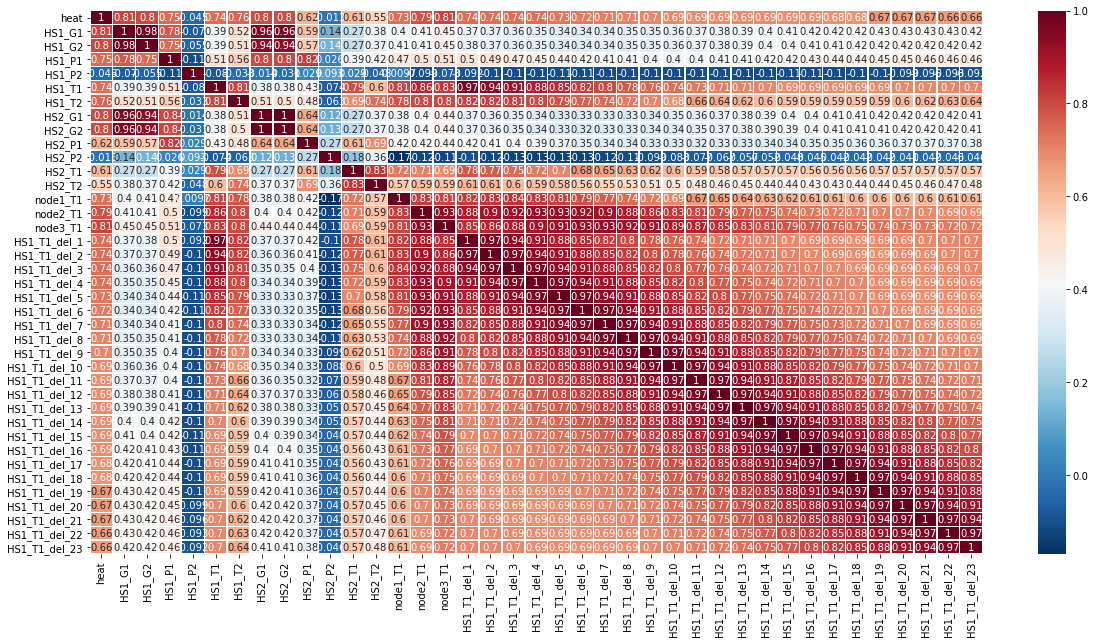

In [77]:
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix_winter2, xticklabels=corr_matrix_winter2.columns, yticklabels=corr_matrix_winter2.columns,
            cmap='RdBu_r', annot=True,linewidth=0.5);

### When the winter model is filtered using heat, the highest parameters are also: heat, HS_T1_del4, HS1_T2, and HS2_T1. 

In [78]:
#Analysis of winter model when filtered by heat
reg_winter_2 = linear_model.LinearRegression()
reg_winter_2.fit(sub2_winter[['heat','HS1_T1_del_4','HS1_T2','HS2_T1']], sub2_winter['node1_T1'])

LinearRegression()

In [79]:
reg_winter_2.score(sub2_winter[['heat','HS1_T1_del_4','HS1_T2','HS2_T1']], sub2_winter['node1_T1'])

0.7550210121968939

In [102]:
reg_winter_2.coef_

array([0.00106214, 0.37738452, 0.48895896, 0.14020258])

In [103]:
reg_winter_2.intercept_

11.718470378984144

### The equation for the linear regression has the shape of: 
y = 11.718470378984144 + 0.00106214(heat) + 0.37738452(HS1_T1_del_4) + 0.48895896(HS1_T2) + 0.14020258(HS2_T1)

#### The model's score increases from 54% to 75%, which yields the highest accuracy out of all models. 